# Coursera Final Project 

- Author : Cha Myeongseop
- Data : 2019-10-21
- Version :  2.0

# Data pipeline

> Set initial environment
- Set dependency
- Load dataset
- Merge dataset

> Data Preprocessing
- Check data distribution
- Check data leakage
- Clean dataset (outlier, missing value) 

> Feature engineering
- EDA 
- Feature generation
- Mean coding (Advanced feature 1)
- Text extraction for new feature (Advanced feature 2)
- Select golden features.

> Modeling 
- Tree based models(catboost, xgboost, random forest)
- Linear model(linear regression)
- Cluster model (KNN)
- Ensemble, Stacking

#### Reference
- https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
- https://www.kaggle.com/dlarionov/feature-engineering-xgboost
- https://www.kaggle.com/bhaveshthaker/data-preparation-exploratory-analysis-and-modeling
- https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda

# Set Initial envirionment
### Dependencies

In [1]:
import numpy as np
import pandas as pd
import datetime
import warnings
import sys
import pickle
from itertools import product

# Labelling
from sklearn.preprocessing import LabelEncoder

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler


%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
cats = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')

### Merge dataset

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Data description 
- There are duplicate name on shop_name : We should incorporate duplicate shop_id as one shop_id
- There is weird value on item_price as -1 : We will replace minus value with median value.
- There are a few outliers : We will erase 0 ~ 1percent, 99 ~ 100% range (We will analyze 1 ~ 99% range)

In [4]:
# Columns consists of 10 features.
train['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [5]:
# 6 Columns are numeric features
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


## Check data leakage

In [6]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
leakage_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
leakage_train = leakage_train[leakage_train['item_id'].isin(test_item_ids)]

In [7]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', leakage_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


### Clean Dataset
### Outlier
- There is weird values between 2,000 and 2,500 in item_cnt_day
- There is weird values about 300,000 in item_price
- There is one tiem with price below zero. We will replace it with median

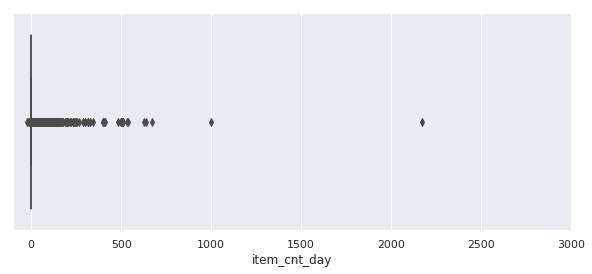

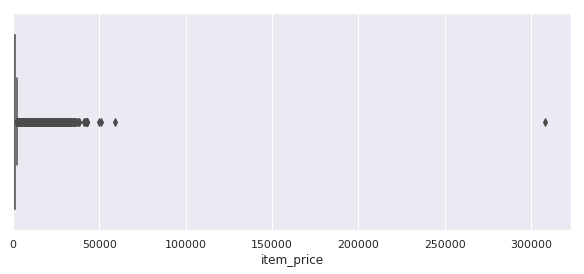

In [8]:
# EDA for checking outlier.
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.05)
sns.boxplot(x=train.item_price)

- We will erase outlier and set new range(item_price, item_cnt_day)
- We will replace minus value with median(shop_id ==32, item_id==2973, data_block_num==4, item_price>0)


In [9]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [10]:
# Fill noise records.
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

# Feature Engineering

### Text incorporation & extraction (Advanced Feature Ⅱ)
- I have employed one of techniques from dlarionov's kernel (https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
  - he found that there are duplicated shop_name and redesign tarin_dataset.
  - he apply new text features on train, test dataset.
- I incorporateed duplicate shop_name as one shop_id.
- I extracted and seperated text information (shop_name) into "city", "city_code"

In [11]:
# shop_name : Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# shop_name: Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# shop_name : Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Extract city_name, city_code from shop_name
- I got inspiration for generating categorical features such as city name, city code from kyakovlev
- he tried to seperate city name, shop name. There is meaningful pattern in shop_name but it is hard for me to capture it because shop_name is russian.
- link : https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data

In [ ]:
# # I generated text feature engineering but i did not exploit these features for ML models.
# shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
# shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
# shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
# shops.head()

## Utilize data leakage
- I bring sample code from dimitreoliveira's kernel. After checking data leakage, I will use both shop_id and item_id
- link : https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda


In [12]:
train_monthly = leakage_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [13]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [14]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [15]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

# Feature generation (time, revenue, label)

In [16]:
# Revenue
train_monthly['revenue'] = train_monthly['item_price'] *  train_monthly['item_cnt']
# Year
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
# Month
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [17]:
# Time lag
time_shift = [1, 2, 3, 4, 5, 6]

for lag in time_shift:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [18]:
train_monthly['item_trend'] = train_monthly['item_cnt']
for lag in time_shift:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(time_shift) + 1

In [19]:
# Add label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# EDA

### Item Category Distribution
#### Category nuber 40 is the biggest number of items

In [20]:
items_category_dist = items.item_category_id.value_counts().iloc[:10]
items_category_dist = items_category_dist.sort_index(sort_remaining=True)

Text(0.5, 1.0, 'Item Category Distribution')

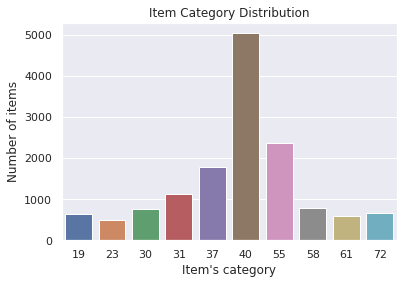

In [21]:
sns.barplot(items_category_dist.index, items_category_dist.values)
plt.xlabel("Item's category")
plt.ylabel("Number of items")
plt.title("Item Category Distribution")

## Shop Distribution

#### Shop_id(25, 31) is the biggest shops.

In [22]:
shops_dist = sales.groupby('shop_id')['item_cnt_day'].sum()
shops_dist = shops_dist.sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Shop Distribution')

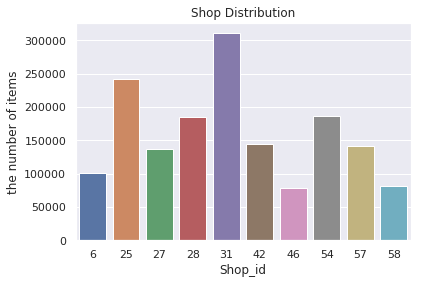

In [23]:
sns.barplot(shops_dist.index, shops_dist.values)
plt.xlabel("Shop_id")
plt.ylabel("the number of items")
plt.title("Shop Distribution")

## Monthly Item Distribution 

In [24]:
price_cnt_month = sales.groupby('date_block_num')['item_price'].sum()

Text(0.5, 1.0, 'Total price of items sold in each month')

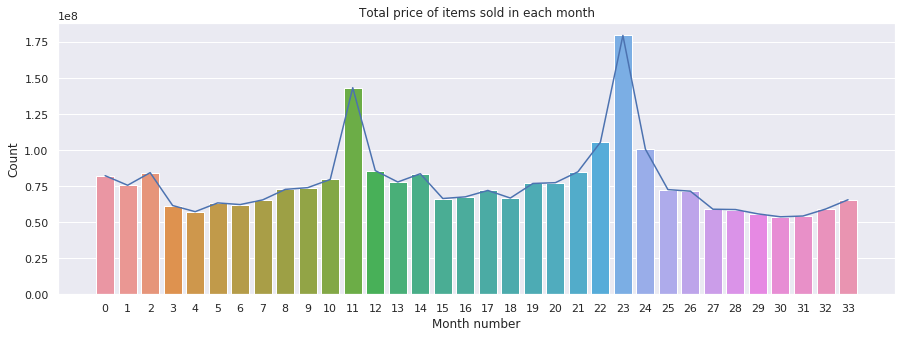

In [25]:
plt.figure(figsize=(15,5))
sns.barplot(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

## Split Train / Test dataset

In [26]:
x_train = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
x_validation = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
x_test = train_monthly.query('date_block_num == 33').copy()

x_train.dropna(subset=['item_cnt_month'], inplace=True)
x_validation.dropna(subset=['item_cnt_month'], inplace=True)

x_train.dropna(inplace=True)
x_validation.dropna(inplace=True)

print('Train data:', x_train.shape[0])
print('Validation data:', x_validation.shape[0])
print('Test data:', x_test.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (x_train.shape[0], ((x_train.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (x_validation.shape[0], ((x_validation.shape[0]/train_monthly.shape[0])*100)))

Train data: 4951800
Validation data: 990360
Test data: 198072
Train set records: 4951800 (74% of complete data)
Validation set records: 990360 (15% of complete data)


## Mean encoding (Advanced FeatureⅠ)
- I employ one of technique from dimitreoliveira. becuase i was amazed to employ mean encoding works after seperating train, validation set.  
- link: https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda
- After dividing train, validation set, I apply new features using mean encoding to x_train, x_validation.

In [27]:
# Shop mean encoding.
gp_shop_mean = x_train.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = x_train.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = x_train.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = x_train.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = x_train.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
x_train = pd.merge(x_train, gp_shop_mean, on=['shop_id'], how='left')
x_train = pd.merge(x_train, gp_item_mean, on=['item_id'], how='left')
x_train = pd.merge(x_train, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
x_train = pd.merge(x_train, gp_year_mean, on=['year'], how='left')
x_train = pd.merge(x_train, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
x_validation = pd.merge(x_validation, gp_shop_mean, on=['shop_id'], how='left')
x_validation = pd.merge(x_validation, gp_item_mean, on=['item_id'], how='left')
x_validation = pd.merge(x_validation, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
x_validation = pd.merge(x_validation, gp_year_mean, on=['year'], how='left')
x_validation = pd.merge(x_validation, gp_month_mean, on=['month'], how='left')

## Prepare dataset for building models

In [28]:
# Create train and validation sets and labels. 
X_train = x_train.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = x_train['item_cnt_month'].astype(int)
X_validation = x_validation.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = x_validation['item_cnt_month'].astype(int)

In [29]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [30]:
latest_records = pd.concat([x_train, x_validation]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [ ]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
for dataset in sets:
    for item_id in dataset['item_id'].unique():
        for column in dataset.columns:
            item_median = dataset[(dataset['item_id'] == item_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [32]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

## Modelling 
### Tree-based model
### Catboost

In [33]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

CatBoostError: Invalid type for cat_feature[non-default value idx=19,feature_idx=7]=1677.2 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [ ]:
print('Model params:', catboost_model.get_params())

### Catboost feature importance

In [ ]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

## XGBoost

In [ ]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'item_cnt_shifted4', 
                'item_cnt_shifted5', 'item_cnt_shifted6', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

## XGBoost feature importance

In [ ]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [ ]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

## Linear Model (Linear Regression)